# Decision tree


#### Import and clean data 

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score

from matplotlib.pyplot import figure
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import display
from data_processing import prepare_data, split_data
from helper_functions import get_metrics

In [2]:
# Clean the data
data = prepare_data('healthcare-dataset-stroke-data.csv')

# Split the data into training, testing and validation data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(data, split_size=(0.6, 0.2, 0.2))

### Basic model

In [3]:
def train_and_predict(model, training_data, training_labels, testing_data):
    """
    This function trains an instance of the model based on input training data and training labels. 
    It returns the predicted labels for the training_data and the testing_data in a tuple.
    """
    # Fit the data to the model
    model.fit(training_data, training_labels)
    
    # Predict labels for training and testing data
    train_predict = model.predict(training_data)
    test_predict = model.predict(testing_data)
    
    # Return predictions over the training (to test model accuracy for learned data) and testing data
    return train_predict, test_predict

# Make an instance of the DecisionTreeClassifier
tree = DecisionTreeClassifier(min_samples_split = 2, max_depth = 500)

# Get the predictions
prediction_train, prediction_test = train_and_predict(tree, train_data, train_labels, test_data)

# Print the accuracies
print("For the training data:")
train_acc, train_balacc = get_metrics(train_labels, prediction_train, verbose = True)

print("For the testing data")
test_acc, testbalacc = get_metrics(test_labels, prediction_test, verbose = True)

For the training data:
accuracy: 100.0000 % 

balanced accuracy: 100.0000 %
sensitivity: 1.0000
specificity: 1.0000 

confusion matrix: 
[[2916    0]
 [   0  149]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

For the testing data
accuracy: 92.1722 % 

balanced accuracy: 57.9424 %
sensitivity: 0.2000
specificity: 0.9588 

confusion matrix: 
[[932  40]
 [ 40  10]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



### Parameter optimization options
There are multiple ways to optimize a decision tree. We will look at:
1. Early stopping &rarr; where to stop
2. Pruning &rarr; cutting leafs

#### Option 1: Early stopping

Make sure the tree is less deep, by using a minimum number of samples that must be present to split the leaf or by giving a maximum tree depth to the algoritm. First we try to find the best minimum number of samples. 

In [4]:
def plot_accuracy(splits, training_acc, val_acc, title, x_lab, y_lab = 'accuracy'):
    """
    Plot the a list with an amount of splits and a list of measures of training and validation accuracy. Has the option of 
    setting a different title.
    """
    plt.plot(splits, training_acc, 'b')
    plt.plot(splits, val_acc, 'r')
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.legend(['train accuracy', 'validation accuracy'])
    plt.ylim([0, 1.1])
    plt.title(title)
    plt.show()

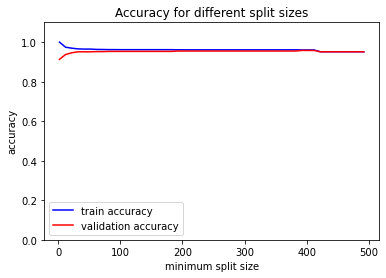

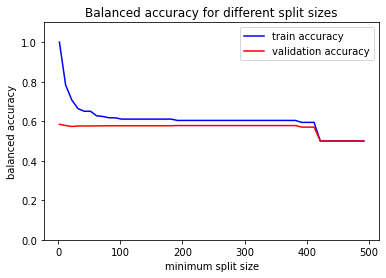

best split size: 2
highest validation accuracy: 0.5842798353909465


In [5]:
def try_upgrade(x_min, x_max, x_step, data, titles, x_label, model = DecisionTreeClassifier, upgrade = 'min_samples_split'):
    ''' 
    Data is tuple with both training data and labels and testing data and labels
    Titles is a list with first the title for accuracy and then for balanced accuracy
    
    '''

    training_data, training_labels, vali_data, vali_labels = data
    
    # Create a range for different minimal split sizes
    x = np.arange(x_min, x_max, x_step)

    # The accuracy for the various split sizes will be appended to this
    training_accuracy = []
    vali_accuracy = []
    training_accuracy_balanced = []
    vali_accuracy_balanced = []

    # Loop over all minimum split sizes
    for value in x:
        
        dictionary = {upgrade: value}
    
        # Create and fit model and predict labels
        tree = model(**dictionary)
        training_predict, vali_predict = train_and_predict(tree, training_data, training_labels, vali_data)

        # Get accuracy for training and validation data
        train_acc, train_bal_acc = get_metrics(train_labels, training_predict)
        val_acc, val_bal_acc = get_metrics(vali_labels, vali_predict)

        # Append the accuracies to the lists
        training_accuracy.append(train_acc)
        training_accuracy_balanced.append(train_bal_acc)
        vali_accuracy.append(val_acc)
        vali_accuracy_balanced.append(val_bal_acc)
    
    # Plot the findings
    plot_accuracy(x, training_accuracy, vali_accuracy, titles[0], x_label)
    plot_accuracy(x, training_accuracy_balanced, vali_accuracy_balanced, 
                  titles[1], x_label, 'balanced accuracy')
    
   
    # Find the best value that has the maximum validation accuracy
    index_max = np.argmax(vali_accuracy_balanced)
    best_x = x[index_max]
    high_val = vali_accuracy_balanced[index_max]
    
    return best_x, high_val

data_model = (train_data, train_labels, val_data, val_labels)
titles = ["Accuracy for different split sizes", "Balanced accuracy for different split sizes"]
best_split, validation = try_upgrade(2, 500, 10, data_model, titles, 'minimum split size', upgrade = 'min_samples_split')

print(f'best split size: {best_split}')
print(f'highest validation accuracy: {validation}')


Then we look for the best tree depth.

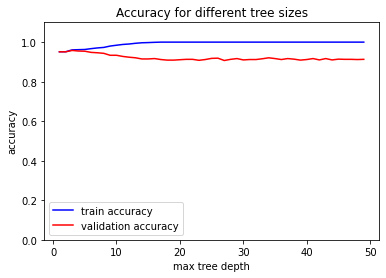

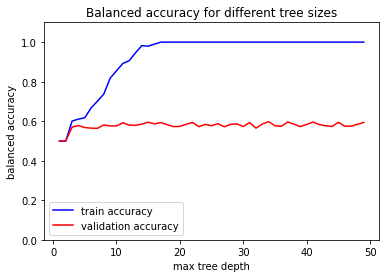

best tree size: 34
highest validation accuracy: 0.597880658436214


In [6]:
titles = ['Accuracy for different tree sizes', 'Balanced accuracy for different tree sizes']
best_depth, validation_size = try_upgrade(1, 50, 1, data_model, titles, 'max tree depth', upgrade = 'max_depth')
print(f'best tree size: {best_depth}')
print(f'highest validation accuracy: {validation_size}')

In [8]:
print(f'To maximize the tree depth it is best to give a min_split_size of {best_split} or a max_depth of ' 
      f'{best_depth} to the decision tree')

To maximize the tree depth it is best to give a min_split_size of 2 or a max_depth of 34 to the decision tree


It is not necessary to give both optimized values to a decision tree, because this will create a tree with too little depth, since both parameters are restrictions for the tree depth. 

### Option 2: pruning

Number of nodes in the last tree is: 1 with ccp_alpha: 0.0068885992747864345


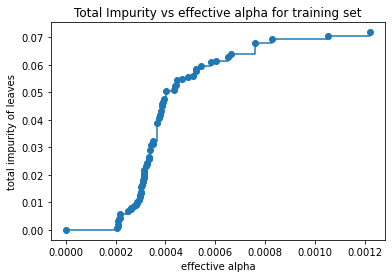

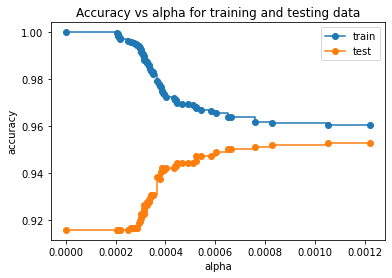

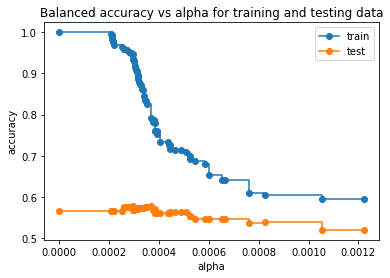

In [9]:
#TODO refereren!!

# Create a decision tree
tree = DecisionTreeClassifier(random_state=0)

# Compute the cost complexity parameter (ccp_alpha)
# Greater ccp_alpha means more nodes are pruned and impurities is information about how pure the nodes are
path = tree.cost_complexity_pruning_path(train_data, train_labels)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plot the cost complexity parameter and the impurities for all trees but the one with only one node
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

# Create an empty list to save trees
trees = []

# Loop over all used cost complexity parameters 
for ccp_alpha in ccp_alphas:
    
    # Create a decision tree using this alpha
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    
    # Fit the tree on the data
    tree.fit(train_data, train_labels)
    
    # Add the tree to the list
    trees.append(tree)
    
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(trees[-1].tree_.node_count, ccp_alphas[-1]))

# Remove the tree without splits from the list with trees and the list with alpha's 
trees = trees[:-1]
ccp_alphas = ccp_alphas[:-1]

# Create empty list to save the normal accuracy and the balanced accuracy for both training and testing data
train_scores = []
test_scores = []
train_scores_balanced = []
test_scores_balanced = []

# Loop over all the trees
for tree in trees:
    
    # Get the predicted labels from the tree
    train_predict = tree.predict(train_data)
    test_predict = tree.predict(test_data)
    
    # Compute the accuracy and balanced accuracy
    train_accuracy, train_balanced = get_metrics(train_labels, train_predict)
    test_accuracy, test_balanced = get_metrics(test_labels, test_predict)
    
    # Add values to the correct list
    train_scores_balanced.append(train_balanced)
    train_scores.append(train_accuracy)
    test_scores_balanced.append(test_balanced)
    test_scores.append(test_accuracy)
    
# Plot the accuracies of the training and testing data with the cost complexity parameter
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing data")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

# Plot the balanced accuracies of the training and testing data with the cost complexity parameter
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Balanced accuracy vs alpha for training and testing data")
ax.plot(ccp_alphas, train_scores_balanced, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores_balanced, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

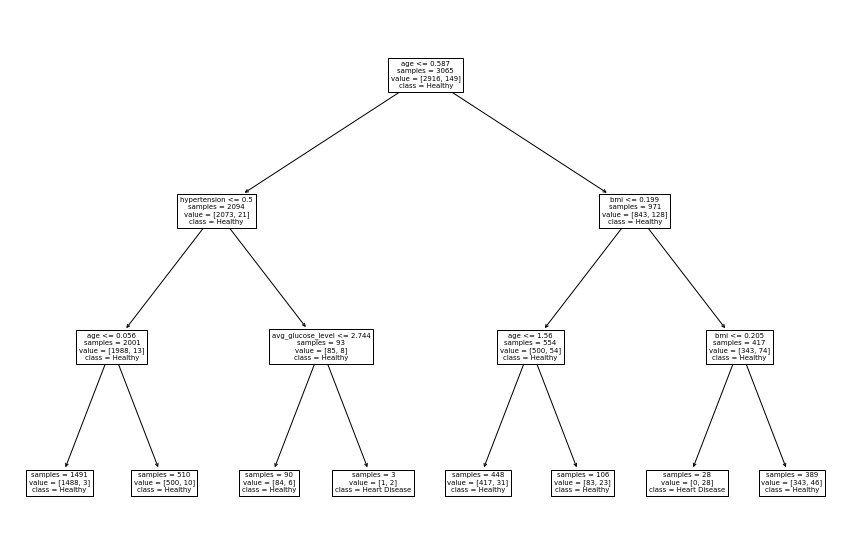

In [11]:
from sklearn import tree

# Plot root of decision tree using this optimal split size, to see what this shows us about important features
d_tree = DecisionTreeClassifier(max_depth = 3, min_samples_split = best_split)
d_tree.fit(train_data, train_labels)

figure(figsize=(15, 10))
tree.plot_tree(d_tree, feature_names=data.columns.values, class_names=['Healthy', 'Heart Disease'], impurity=False);

# Random forest
Try a normal random forest

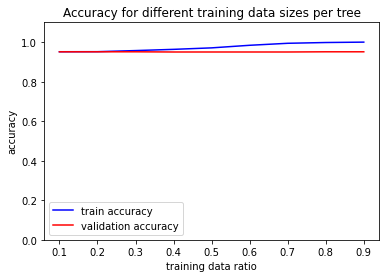

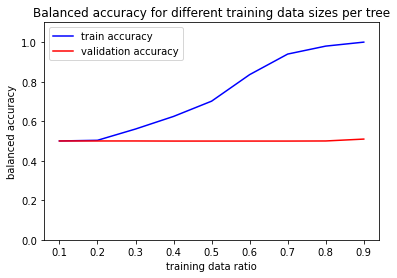

best training data ratio: 0.9
highest validation accuracy: 0.5094855967078189


In [12]:
from sklearn.ensemble import RandomForestClassifier

titles = ['Accuracy for different training data sizes per tree', 'Balanced accuracy for different training data sizes per tree' ]
train_ratio, validation_ratio = try_upgrade(0.1, 1, 0.1, data_model, titles, 'training data ratio', model = RandomForestClassifier, upgrade = 'max_samples')

print(f'best training data ratio: {train_ratio}')
print(f'highest validation accuracy: {validation_ratio}')

# # Train the various trees in the forest on 0.5 of the dataset every time
# model = RandomForestClassifier(max_samples = None)
# train_prediction, test_prediction = train_and_predict(model, train_data, train_labels, test_data)
# print(train_prediction)
# # Print the accuracies
# print("For the training data:")
# train_acc, train_balacc = get_metrics(train_labels, train_prediction, verbose = True)

# print("For the testing data")
# test_acc, testbalacc = get_metrics(test_labels, test_prediction, verbose = True)

# # plotten van max_sample 0 to 1 moet ook nog kunnen
# # To do maandag wellicht

Normal random forests seems to work even worse than a single tree. So we will try to train some trees using all the stroke data and only part of the total dataset; hopefully, this counteracts the imbalance between output classes in the dataset and makes it easier for the model to train.

In [24]:
def resampled_forest(data, stroke_data, non_stroke_data, nr_splits):
    
    training_data, training_labels, testing_data, testing_labels = data
    
    # Get variables to sum to later
    train_predicted = 0
    test_predicted = 0

    # Set the amount of splits we will be dividing our dataset, and also the amount of trees we will train

    # Get the ratio that we will have to use for sampling the dataset for x amount of splits
    ratio = 1 / nr_splits

    # For the amount of splits, sample a new part of the data and train a new decision tree on it
    for split in range(nr_splits):

        # Get a sample of the non-stroke data
        sample_non_stroke = non_stroke_data.sample(frac = ratio)

        # Remove this sample from the dataset so we eventually use all the data to train our forest of trees
        non_stroke_data.drop(sample_non_stroke.index)

        # Append the non-stroke sample and our data for stroke patients to actually train the tree on
        mini_train = pd.concat((sample_non_stroke, stroke_data))

        # Get the labels belonging to this mini-train set
        mini_train_labels = training_labels[mini_train.index]

        # Make an instance of a DecisionTree
        model = DecisionTreeClassifier()

        # Train our model on the mini-trainingset 
        model.fit(mini_train, mini_train_labels)

        # Predict labels for entire training data and testing data with this model
        train_predict = model.predict(training_data)
        test_predict = model.predict(testing_data)

        # Add the predicted scores for this model to the total scores over all trees
        train_predicted += train_predict
        test_predicted += test_predict

        # Calculate if the majority of the trees classified the training and testing sample as stroke or not
        train_predictions = train_predicted / nr_splits >= 0.5
        test_predictions = test_predicted / nr_splits >= 0.5

    return train_predictions, test_predictions 

11 0.7717489711934156


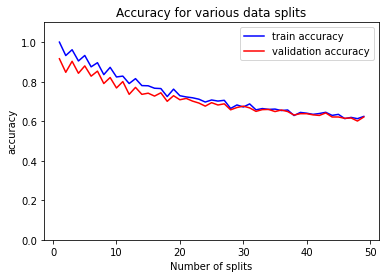

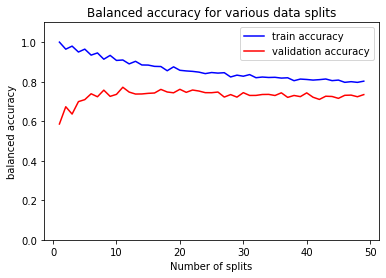

In [27]:
# Seperate data from patients with stroke from no stroke by making a mask based on the labels 
stroke_mask = train_labels == 1
stroke = train_data[stroke_mask]

# This selects the opposite of the mask, to get patients without stroke
non_stroke = train_data[~stroke_mask]

splits_range = np.arange(1, 50, 1)

# Create empty lists to save accuracies
training_accuracy = []
vali_accuracy = []
training_accuracy_balanced = []
vali_accuracy_balanced = []

for splits in splits_range:

    training_predictions, val_predictions = resampled_forest(data_model, stroke, non_stroke, splits)

    # Get accuracy for training and validation data
    train_acc, train_bal_acc = get_metrics(train_labels, training_predictions)
    val_acc, val_bal_acc = get_metrics(val_labels, val_predictions)

    # Append the accuracies to the lists
    training_accuracy.append(train_acc)
    training_accuracy_balanced.append(train_bal_acc)
    vali_accuracy.append(val_acc)
    vali_accuracy_balanced.append(val_bal_acc)

index_max = np.argmax(vali_accuracy_balanced)
best_split = splits_range[index_max]
high_val = vali_accuracy_balanced[index_max]

print(best_split, high_val)
    
# Plot the findings
plot_accuracy(splits_range, training_accuracy, vali_accuracy, 'Accuracy for various data splits', 'Number of splits')
plot_accuracy(splits_range, training_accuracy_balanced, vali_accuracy_balanced, 
              'Balanced accuracy for various data splits', 'Number of splits', 'balanced accuracy')

In [28]:
data = train_data, train_labels, test_data, test_labels

training_predictions, test_predictions = resampled_forest(data, stroke, non_stroke, best_split)

# Print the accuracies
get_metrics(train_labels, training_predictions, verbose = True);
get_metrics(test_labels, test_predictions, verbose = True);


accuracy: 82.9038 % 

balanced accuracy: 91.0151 %
sensitivity: 1.0000
specificity: 0.8203 

confusion matrix: 
[[2392  524]
 [   0  149]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

accuracy: 79.6477 % 

balanced accuracy: 76.9691 %
sensitivity: 0.7400
specificity: 0.7994 

confusion matrix: 
[[777 195]
 [ 13  37]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

